In [1]:
# based on https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/mnist_lstm/train.py

In [2]:
# Copyright 2022 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# =============================================================================
"""LSTM model training for MNIST recognition

This script is based on:
https://www.tensorflow.org/lite/models/convert/rnn
https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/experimental_new_converter/Keras_LSTM_fusion_Codelab.ipynb

"""


'LSTM model training for MNIST recognition\n\nThis script is based on:\nhttps://www.tensorflow.org/lite/models/convert/rnn\nhttps://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/examples/experimental_new_converter/Keras_LSTM_fusion_Codelab.ipynb\n\n'

In [3]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"
from absl import logging        # type: ignore
import numpy as np              # type: ignore
import tensorflow as tf         # type: ignore
import matplotlib.pyplot as plt # type: ignore

Configuration

In [4]:
epochs = 20
save_dir = "../../Code/04_Bilderkennung"
quantize = True
lstm = True

save_tf_model = False

Model Definition

In [5]:
def create_LSTM_model(units=20):
  """Create a keras LSTM model for MNIST recognition

    Args:
        units (int, optional): dimensionality of the output space for the model.
          Defaults to 20.

    Returns:
        tf.keras.Model: A Keras LSTM model
    """

  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(28, 28), name="input"),
      tf.keras.layers.LSTM(units, return_sequences=True),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax, name="output")
  ])
  model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
  model.summary()
  return model


In [6]:
def create_CNN_model(num_filters=4, num_neurons=16):
    """Create a Keras CNN model for MNIST recognition

    Args:
        num_filters (int, optional): Number of filters in the Conv2D layer. Defaults to 4.
        num_neurons (int, optional): Number of neurons in the Dense layer. Defaults to 16.

    Returns:
        tf.keras.Model: A Keras CNN model
    """

    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1), name="input"),
        tf.keras.layers.Conv2D(num_filters, (3,3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_neurons, activation='relu'),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax, name="output")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    model.summary()
    return model

In [7]:
def train_model(epochs, x_train, y_train):
  """Train keras LSTM model on MNIST dataset

    Args: epochs (int) : number of epochs to train the model
        x_train (numpy.array): list of the training data
        y_train (numpy.array): list of the corresponding array

    Returns:
        tf.keras.Model: A trained keras LSTM model
  """
  if lstm:
    model = create_LSTM_model()
  else:
    model = create_CNN_model()

  callback = tf.keras.callbacks.EarlyStopping(
      monitor="val_loss",
      patience=3)  # early stop if validation loss does not drop anymore
  model.fit(x_train,
            y_train,
            epochs=epochs,
            validation_split=0.2,
            batch_size=32,
            callbacks=[callback])
  return model

Training Data

In [8]:
def get_train_data():
  """Get MNIST train and test data

    Returns:
        tuple: (data, label) pairs for train and test
    """
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  x_train = x_train / 255.  # normalize pixel values to 0-1
  x_train = x_train.astype(np.float32)
  return (x_train, y_train)

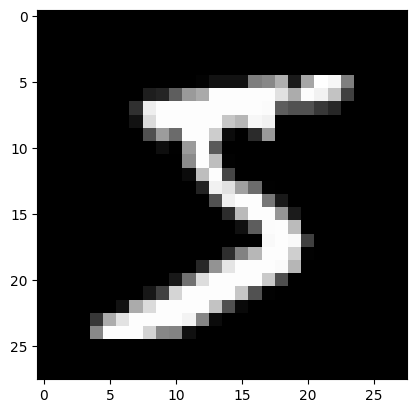

y_train[0]: 5


In [9]:
(x_train, y_train) = get_train_data()

plt.imshow(x_train[0], cmap='gray')
plt.show()
print("y_train[0]:", y_train[0])

Quantization

In [10]:
def convert_quantized_tflite_model(model, x_train):
  """Convert the save TF model to tflite model, then save it as .tflite flatbuffer format

    See
    https://www.tensorflow.org/lite/performance/post_training_integer_quant#convert_using_integer-only_quantization

    Args:
        model (tf.keras.Model): the trained Model
        x_train (numpy.array): list of the training data

    Returns:
        The converted model in serialized format.
  """

  def representative_dataset_gen(num_samples=100):
    for data in x_train[:num_samples]:
      yield [data.reshape(1, 28, 28)]

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  return tflite_model

TensorFlow Lite Model

In [11]:
def convert_tflite_model(model):
  """Convert the save TF model to tflite model, then save it as .tflite flatbuffer format

    Args:
        model (tf.keras.Model): the trained Model

    Returns:
        The converted model in serialized format.
  """
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  return tflite_model


def save_tflite_model(tflite_model, save_dir, model_name):
  """save the converted tflite model

  Args:
      tflite_model (binary): the converted model in serialized format.
      save_dir (str): the save directory
      model_name (str): model name to be saved
  """
  if not os.path.exists(save_dir):
    os.makedirs(save_dir)
  save_path = os.path.join(save_dir, model_name)
  with open(save_path, "wb") as f:
    f.write(tflite_model)
  logging.info("Tflite model saved to %s", save_dir)

Fix the Input

In [12]:
def prepare_trained_model(trained_model):
  """Fix the input of the trained model for inference

    Args:
        trained_model (tf.keras.Model): the trained model

    Returns:
        run_model (tf.keras.Model): the trained model with fixed input tensor size for inference
  """
  # TFLite converter requires fixed shape input to work, alternative: b/225231544
  fixed_input = tf.keras.layers.Input(shape=[28, 28],
                                      batch_size=1,
                                      dtype=trained_model.inputs[0].dtype,
                                      name="fixed_input")
  fixed_output = trained_model(fixed_input)
  run_model = tf.keras.models.Model(fixed_input, fixed_output)
  return run_model

Main

In [13]:
x_train, y_train = get_train_data()
trained_model = train_model(epochs, x_train, y_train)
run_model = prepare_trained_model(trained_model)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 28, 20)            3920      
                                                                 
 flatten (Flatten)           (None, 560)               0         
                                                                 
 output (Dense)              (None, 10)                5610      
                                                                 
Total params: 9530 (37.23 KB)
Trainable params: 9530 (37.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1500/1500 [==============================] - 35s 8ms/step - loss: 0.3753 - accuracy: 0.8898 - val_loss: 0.1648 - val_accuracy: 0.9516
Epoch 2/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1451 - accuracy: 0.9562 - val_loss: 0.1163 - val_accuracy: 0.9

In [14]:

# Save the tf model
if save_tf_model:
  run_model.save(save_dir, save_format="tf")
  logging.info("TF model saved to %s", save_dir)

if quantize:
# Convert and save the quantized model
  quantized_tflite_model = convert_quantized_tflite_model(run_model, x_train)
  save_tflite_model(quantized_tflite_model,
                    save_dir,
                    model_name="mnist_lstm_quant.tflite" if lstm else "mnist_cnn_quant.tflite")
else:
  # Convert and save the model to .tflite
  tflite_model = convert_tflite_model(run_model)
  save_tflite_model(tflite_model,
                    save_dir,
                    model_name="mnist_lstm.tflite" if lstm else "mnist_cnn.tflite")

INFO:tensorflow:Assets written to: /var/folders/yk/81mgpql17txc1f4grnlsknyc0000r9/T/tmpbtqg_q5d/assets


INFO:tensorflow:Assets written to: /var/folders/yk/81mgpql17txc1f4grnlsknyc0000r9/T/tmpbtqg_q5d/assets
/Users/linkedin/tinyml-microcontroller-5901431/Notebooks/venv/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1715024222.186374 1632580 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1715024222.186414 1632580 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-05-06 21:37:02.187483: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/yk/81mgpql17txc1f4grnlsknyc0000r9/T/tmpbtqg_q5d
2024-05-06 21:37:02.197325: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-06 21:37:02.197343: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/yk/81mgpql17txc1f4grnlsknyc0000r9/T/tmpbtqg_q5d
2024-0

In [18]:
# show file size of all .tflite files in ../../Code/04_Bilderkennung
import os
for file in os.listdir("../../Code/04_Bilderkennung"):
    if file.endswith(".tflite"):
        statinfo = os.stat(os.path.join("../../Code/04_Bilderkennung", file))
        print(f"File size of {file}: {statinfo.st_size} bytes")



File size of mnist_lstm_quant.tflite: 13992 bytes
